<img src="https://raw.githubusercontent.com/iterative/datachain/main/docs/assets/datachain-sys-theme.svg" alt="Dataset" style="width: 200px;"/>

# Tutorial: Enhancing Video Dataset Management and Frame-Level Annotation for YOLOv8 Pose Detection projects

This tutorial dives into techniques to manage video and image datasets for Video Analytics and Vision AI projects. 

**📋 Topics covered:**
1. Building a Video DataChain for `kinetics-700-2020` video dataset
2. Creating a Data Model for YOLOv8 Pose Detection projects
3. Integrating Video-Level Annotations from CSV
5. Extract and Manage Video Frames
6. Running Pose Detection with YOLOv8 and Saving to DataChain
7. Visualizing Pose Data

# 🆕 Building a Video DataChain for `kinetics-700-2020` video dataset

Note: only `validation` split is used for the example purposes

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from datachain import DataChain, DataModel, C, File

## Create a DataChain from a S3 bucket

In [2]:
# # Create a DataChain from previously save dataset

# ds = (
#     DataChain.from_dataset("kinetics-700-2020-val")
# )

# ds.show(3)

## Create a DataChain from a local directory of videos

**(OPTIONAL) You may skip this and work with data in our public dataset.**

- Download the `kinetics-700-2020` dataset 
- Unzip data into `examples/kinetics_actions_video/data` directory 


In [3]:
# Create a DataChain

DATA_PATH = "data/validation/"

video_dc = (
    DataChain.from_storage(DATA_PATH, type='image')
    .filter(C("file.path").glob("*.mp4"))
)
video_dc.show(3)

/Users/mikhailrozhkov/.pyenv/versions/3.12.4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processed: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00, 511.50 rows/s]
Generated: 4 rows [00:00, 3081.78 rows/s]
Cleanup: 1 tables [00:00, 2916.76 tables/s]


,file,file,file,file,file,file,file,file,file
,source,path,size,version,etag,is_latest,last_modified,location,vtype
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,637366,,0x1.9a357260a80c5p+30,1,2024-07-09 15:51:52.164109+00:00,None,
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,510940,,0x1.9a35765c30b14p+30,1,2024-07-09 15:56:07.047551+00:00,None,
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,1217179,,0x1.9a356ef01a30fp+30,1,2024-07-09 15:48:12.025577+00:00,None,



[Limited by 3 rows]


# Creating a Data Model for YOLOv8 Pose Detection projects

In [4]:
from datachain import DataModel
from pydantic import Field


class Video(DataModel):
    video_id: str
    duration: float
    width: int
    height: int
    fps: float
    frame_count: int
    codec: int

class Frame(DataModel):
    video_id: str
    frame_id: str
    width: int
    height: int


class BBox(DataModel):
    x1: float = 0.0
    y1: float = 0.0
    x2: float = 0.0
    y2: float = 0.0
    
class Keypoints(DataModel):
    x: list[float] = []
    y: list[float] = []
    visible: list[float] = []

class Detection(DataModel):
    name: str = ""
    cls: int = Field(99999, alias='class')
    confidence: float = 0.0
    boxes: BBox = Field(default_factory=BBox, alias='box')
    keypoints: Keypoints = Field(default_factory=Keypoints)
    orig_shape: list[int] = []
    is_detected: bool = False

    class Config:
        populate_by_name = True
        from_attributes = True

# Integrating Video-Level Annotations from CSV

Many datasets come with pre-existing annotations in CSV format. Here's how to integrate them seamlessly:

CSV Parsing: Implement robust CSV parsing with error handling.
Mapping: Create a mapping between CSV fields and your data model.
Validation: Implement checks to ensure data integrity during import.

## Add Video metadata

In [5]:
from src.video_utils import get_video_metadata

def add_video_metadata(file) -> Video: 
    video_id = file.get_file_stem().split('_')[0]
    metadata = get_video_metadata(file.get_path())
    return Video(video_id=video_id, **metadata)
    

video_dc = video_dc.map(video=lambda file: add_video_metadata(file), output={'video': Video})
video_dc.show(3)

Preparing: 1000 rows [00:00, 137023.98 rows/s]
Processed: 1000 rows [00:02, 394.21 rows/s]
Cleanup: 2 tables [00:00, 3975.64 tables/s]


,file,file,file,file,file,file,file,file,file,video,video,video,video,video,video,video
,source,path,size,version,etag,is_latest,last_modified,location,vtype,video_id,duration,width,height,fps,frame_count,codec
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,637366,,0x1.9a357260a80c5p+30,1,2024-07-09 15:51:52.164109+00:00,None,,22QytzFKlos,10.00,480,360,25.000000,250,875967080
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,510940,,0x1.9a35765c30b14p+30,1,2024-07-09 15:56:07.047551+00:00,None,,G6GFZK4u1rE,10.01,202,360,23.976024,240,875967080
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,1217179,,0x1.9a356ef01a30fp+30,1,2024-07-09 15:48:12.025577+00:00,None,,CJqBugqR6zE,10.01,640,360,29.970030,300,875967080



[Limited by 3 rows]


## Create Video Labels DataChain

In [6]:
# Video annotations 
video_labels_path = "data/k700_annotations_val.csv"


k700_dc = (
    DataChain.from_csv(os.path.abspath(video_labels_path))
    .select_except("source")
    .save()
)

print(k700_dc.count())
k700_dc.show(3)

Processed: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00, 552.75 rows/s]
Generated: 4 rows [00:00, 3289.65 rows/s]
Cleanup: 1 tables [00:00, 5526.09 tables/s]
Processed: 0 rows [00:00, ? rows/s]
Parsed by pyarrow: 0 rows [00:00, ? rows/s]

Generated: 0 rows [00:00, ? rows/s]

Generated: 3549 rows [00:00, 35488.17 rows/s]

Generated: 9434 rows [00:00, 49228.78 rows/s]

Generated: 14357 rows [00:00, 28921.06 rows/s]

Generated: 20001 rows [00:00, 25043.75 rows/s]
Parsed by pyarrow: 22562 rows [00:00, 27344.69 rows/s]

Generated: 24460 rows [00:00, 29213.73 rows/s]

Generated: 30001 rows [00:01, 25553.24 rows/s]
Parsed by pyarrow: 33314 rows [00:01, 27717.71 rows/s]
Processed: 1 rows [00:01,  1.26s/ rows]
Generated: 33314 rows [00:01, 27790.01 rows/s]
Saving: 33314 rows [00:00, 55266.16 rows/s]
Cleanup: 1 tables [00:00, 355.75 tables/s]

33314


,youtube_id,time_start,time_end,split,class,label
0,---QUuC4vJs,84,94,validate,616,testifying
1,--GkrdYZ9Tc,0,10,validate,673,washing feet
2,--nQbRBEz2s,104,114,validate,3,air drumming



[Limited by 3 rows]


## Add Annotations to Video Dataset

In [7]:
# Add annotations to Dataset

dc = (
    video_dc
    # .merge(kinetics_dc, on="video_id", right_on="video_id", inner=True)
    .merge(k700_dc, on="video.video_id", right_on="youtube_id", inner=True)
    .save("k700-val")
)

print(dc.count())
dc.show(3)

Preparing: 1000 rows [00:00, 161183.00 rows/s]
Processed: 1000 rows [00:02, 387.25 rows/s]
Saving: 869 rows [00:00, 35888.29 rows/s]
Cleanup: 8 tables [00:00, 11362.83 tables/s]

869


,file,file,file,file,file,file,file,file,file,video,video,video,video,video,video,video,youtube_id,time_start,time_end,split,class,label
,source,path,size,version,etag,is_latest,last_modified,location,vtype,video_id,duration,width,height,fps,frame_count,codec,,,,,,
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,637366,,0x1.9a357260a80c5p+30,1,2024-07-09 15:51:52.164109+00:00,None,,22QytzFKlos,10.00,480,360,25.000000,250,875967080,22QytzFKlos,0,10,validate,594,swimming breast stroke
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,510940,,0x1.9a35765c30b14p+30,1,2024-07-09 15:56:07.047551+00:00,None,,G6GFZK4u1rE,10.01,202,360,23.976024,240,875967080,G6GFZK4u1rE,11,21,validate,392,playing didgeridoo
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,1217179,,0x1.9a356ef01a30fp+30,1,2024-07-09 15:48:12.025577+00:00,None,,CJqBugqR6zE,10.01,640,360,29.970030,300,875967080,CJqBugqR6zE,149,159,validate,392,playing didgeridoo



[Limited by 3 rows]


# Build a dataset for top activities

Let's say we want to reduce activities to a list of the most frequent one.

In [8]:
top_activities = ['cheerleading', 'capoeira', 'sword fighting', 'lawn mower racing',
       'high jump', 'tackling', 'dodgeball', 'walking on stilts',
       'skiing slalom', 'hurdling', 'running on treadmill', 'playing polo',
       'pull ups', 'wrestling', 'battle rope training', 'exercising arm',
]


dc_top = (
    DataChain.from_dataset('k700-val')
    .filter(C('label').in_(top_activities))
    .save("k700-top-videos")
)
print(dc_top.count())
dc_top.show(10)

Saving: 39 rows [00:00, 21405.11 rows/s]

39


,file,file,file,file,file,file,file,file,file,video,video,video,video,video,video,video,youtube_id,time_start,time_end,split,class,label
,source,path,size,version,etag,is_latest,last_modified,location,vtype,video_id,duration,width,height,fps,frame_count,codec,,,,,,
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,497572,,0x1.9a3572051388dp+30,1,2024-07-09 15:51:29.269077+00:00,None,,NODUJYMlhzA,9.976633,202,360,29.970030,299,875967080,NODUJYMlhzA,17,27,validate,286,lawn mower racing
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,348068,,0x1.9a3572bbdfc84p+30,1,2024-07-09 15:52:14.968537+00:00,None,,S784KQdKeg0,10.000000,464,260,15.000000,150,875967080,S784KQdKeg0,79,89,validate,286,lawn mower racing
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,1163834,,0x1.9a3574217dfebp+30,1,2024-07-09 15:53:44.373042+00:00,None,,rPwaNTPIgec,10.025143,480,360,29.326266,294,875967080,rPwaNTPIgec,36,46,validate,286,lawn mower racing
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,1070834,,0x1.9a357676feba9p+30,1,2024-07-09 15:56:13.748759+00:00,None,,953jNSAXMKc,9.976633,492,360,29.970030,299,875967080,953jNSAXMKc,254,264,validate,668,walking on stilts
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,743356,,0x1.9a357283dfceap+30,1,2024-07-09 15:52:00.968562+00:00,None,,9sBuHaFeUEI,9.880000,480,360,25.000000,247,875967080,9sBuHaFeUEI,11,21,validate,668,walking on stilts
5,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,1337595,,0x1.9a3573ecf648ep+30,1,2024-07-09 15:53:31.240512+00:00,None,,6Teo8bCDuAw,10.010000,640,360,29.970030,300,875967080,6Teo8bCDuAw,42,52,validate,668,walking on stilts
6,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,661262,,0x1.9a3575344a8e7p+30,1,2024-07-09 15:54:53.072809+00:00,None,,BBB1iQAihGY,10.010000,640,360,29.970030,300,875967080,BBB1iQAihGY,79,89,validate,26,battle rope training
7,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,286808,,0x1.9a356f7fcd39ep+30,1,2024-07-09 15:48:47.950416+00:00,None,,AYF9WardS9M,9.866667,202,360,30.000000,296,875967080,AYF9WardS9M,2,12,validate,26,battle rope training
8,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,245050,,0x1.9a356ea149de8p+30,1,2024-07-09 15:47:52.322138+00:00,None,,aVcUPlNEOS8,10.010010,480,360,23.976000,240,875967080,aVcUPlNEOS8,42,52,validate,26,battle rope training



[Limited by 10 rows]


## Preview a file example

In [9]:
sample_results = list(dc_top.distinct('file.path').limit(10).collect())
example = sample_results[1]
example

(ImageFile(source='file:///', path='Users/mikhailrozhkov/dev/datachain/datachain-examples/computer_vision/kinetics_actions_video/data/validation/battle rope training/AtEODzq0S6A_000037_000047.mp4', size=525844, version='', etag='0x1.9a356edc83b61p+30', is_latest=True, last_modified=datetime.datetime(2024, 7, 9, 15, 48, 7, 128624, tzinfo=datetime.timezone.utc), location=None, vtype=''),
 Video(video_id='AtEODzq0S6A', duration=10.01, width=480, height=360, fps=29.97002997002997, frame_count=300, codec=875967080),
 'AtEODzq0S6A',
 37,
 47,
 'validate',
 26,
 'battle rope training')

In [10]:
from IPython.display import Video

video_path = example[0].get_path()
Video(video_path, width=640, height=360, embed=True)

## Preview a schema

In [11]:
# Signals schema

dc_top.schema

{'file': datachain.lib.file.ImageFile,
 'video': __main__.Video,
 'youtube_id': str,
 'time_start': int,
 'time_end': int,
 'split': str,
 'class': int,
 'label': str}

In [12]:
# File signals schema

dc_top.schema['file'].schema()

{'description': '`DataModel` for reading image files.',
 'properties': {'source': {'default': '', 'title': 'Source', 'type': 'string'},
  'path': {'title': 'Path', 'type': 'string'},
  'size': {'default': 0, 'title': 'Size', 'type': 'integer'},
  'version': {'default': '', 'title': 'Version', 'type': 'string'},
  'etag': {'default': '', 'title': 'Etag', 'type': 'string'},
  'is_latest': {'default': True, 'title': 'Is Latest', 'type': 'boolean'},
  'last_modified': {'default': '1970-01-01T00:00:00Z',
   'format': 'date-time',
   'title': 'Last Modified',
   'type': 'string'},
  'location': {'anyOf': [{'type': 'object'},
    {'items': {'type': 'object'}, 'type': 'array'},
    {'type': 'null'}],
   'default': None,
   'title': 'Location'},
  'vtype': {'default': '', 'title': 'Vtype', 'type': 'string'}},
 'required': ['path'],
 'title': 'ImageFile',
 'type': 'object'}

# Extract and Manage Video Frames

In [13]:
from tqdm import tqdm 

from src.video_utils import split_video_to_frames

## Extract Video Frames

Let's extract every 5th frame videos and save to `data/frames` subdir 

In [14]:
dc_top = DataChain.from_dataset('k700-top-videos')


for file in tqdm(list(dc_top.distinct('file.path').limit(10).collect())):

    video_path = file[0].get_path()
    
    split_video_to_frames(
        video_path, 
        output_dir='data/frames', 
        step=5, # save every 5th frame 
        rewrite=True
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


## Create a Frame DataChain

In [15]:
# Create DataChain for frames

frame_dc = (
    DataChain.from_storage('data/frames', type='image')
    .filter(C("file.path").glob("*.jpg"))
)
frame_dc.show(10)

Processed: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00, 589.67 rows/s]
Generated: 4 rows [00:00, 3407.23 rows/s]
Cleanup: 1 tables [00:00, 3890.82 tables/s]


,file,file,file,file,file,file,file,file,file
,source,path,size,version,etag,is_latest,last_modified,location,vtype
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,37463,,0x1.9b801dec038e2p+30,1,2024-09-10 08:46:51.003472+00:00,None,
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,39670,,0x1.9b801dec26dffp+30,1,2024-09-10 08:46:51.037964+00:00,None,
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,39312,,0x1.9b801dec2a24ap+30,1,2024-09-10 08:46:51.041155+00:00,None,
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,39672,,0x1.9b801dec06b26p+30,1,2024-09-10 08:46:51.006540+00:00,None,
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,39203,,0x1.9b801dec2f436p+30,1,2024-09-10 08:46:51.046155+00:00,None,
5,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,39658,,0x1.9b801dec04a65p+30,1,2024-09-10 08:46:51.004541+00:00,None,
6,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,40585,,0x1.9b801dec27ec9p+30,1,2024-09-10 08:46:51.038988+00:00,None,
7,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,40813,,0x1.9b801dec28f53p+30,1,2024-09-10 08:46:51.039998+00:00,None,
8,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,40002,,0x1.9b801dec05ab7p+30,1,2024-09-10 08:46:51.005537+00:00,None,



[Limited by 10 rows]


## Add Frame annotations 

In [16]:
# Add Frame annotaions 

def add_frame_metadata(file) -> Frame: 
    video_id = file.path.split('/')[-2]
    frame_id = file.get_file_stem().split('frame_')[1]
    width, height = file.read().size
    return Frame(video_id=video_id, frame_id=frame_id, width=width, height=height)

frame_dc = (
    frame_dc
    .map(frame=lambda file: add_frame_metadata(file), output={'frame': Frame})
    .order_by('frame.video_id', 'frame.frame_id')
    .save("k700-top-frames")
)

print(frame_dc.count())
frame_dc.show(5)

Preparing: 548 rows [00:00, 38929.55 rows/s]
Download: 0.00B [00:00, ?B/s]
Download: 25.3MB [00:00, 316MB/s]s]
Processed: 548 rows [00:00, 6844.36 rows/s]
Saving: 548 rows [00:00, 144322.40 rows/s]
Cleanup: 2 tables [00:00, 4771.68 tables/s]

548


,file,file,file,file,file,file,file,file,file,frame,frame,frame,frame
,source,path,size,version,etag,is_latest,last_modified,location,vtype,video_id,frame_id,width,height
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,13052,,0x1.9b801dea0ab04p+30,1,2024-09-10 08:46:50.510438+00:00,None,,AYF9WardS9M,0000,202,360
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,13157,,0x1.9b801dea0b8e1p+30,1,2024-09-10 08:46:50.511284+00:00,None,,AYF9WardS9M,0005,202,360
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,13205,,0x1.9b801dea0c6c4p+30,1,2024-09-10 08:46:50.512132+00:00,None,,AYF9WardS9M,0010,202,360
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,12876,,0x1.9b801dea0d2e3p+30,1,2024-09-10 08:46:50.512872+00:00,None,,AYF9WardS9M,0015,202,360
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,13028,,0x1.9b801dea0dee5p+30,1,2024-09-10 08:46:50.513604+00:00,None,,AYF9WardS9M,0020,202,360



[Limited by 5 rows]


# Running Pose Detection with YOLOv8 and Saving to DataChain

- Ultralitics Keypoints documentation: https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Keypoints
- For the default pose model keypoint indices for human body pose estimation are:

        0: Nose,
        1: Left Eye,
        2: Right Eye,
        3: Left Ear,
        4: Right Ear 
        5: Left Shoulder,
        6: Right Shoulder,
        7: Left Elbow,
        8: Right Elbow 9: Left Wrist,
        10: Right Wrist,
        11: Left Hip,
        12: Right Hip 13: Left Knee,
        14: Right Knee,
        15: Left Ankle,
        16: Right  Ankle




In [17]:
import os
import numpy as np
import pandas as pd

from collections.abc import Iterator
from datachain import DataChain, DataModel, C, File
from ultralytics import YOLO

## Define a Pose Detector 

In [18]:
# The PoseDetector yields keypoints for the all detections on the frame  (assume there is only 1 person on the frame)
class PoseDetector():

    from PIL import Image
    from io import BytesIO

    def __init__(self):
        self.model = YOLO("yolov8n-pose.pt") 

    def predict(self, file, frame) ->  Iterator[Detection]:

        img = file.read()
        results = self.model(img)[0]  # predict on an image

        if results.summary():
            
            # Multiple detections 
            for result in results.summary(normalize=True):
                yield file, frame, Detection(
                    **result, 
                    orig_shape=results.orig_shape, 
                    is_detected=True), frame
        else: 
            
            # No detections
            yield file, frame, Detection(orig_shape=results.orig_shape, is_detected=False)

detector = PoseDetector()

## Run pose detection on top frames 

In [19]:
frames_dc = (
    DataChain.from_dataset("k700-top-frames")
    .filter(C("file.path").glob("*.jpg"))
)

pose_dc = (
    frames_dc
    .shuffle()
    # .limit(3)
    .gen(
        func=detector.predict, 
        params=["file", "frame"], 
        output={'file': File, 'frame': Frame, 'pose': Detection})
    .save('k700-top-frames-pose')
)


Processed: 0 rows [00:00, ? rows/s]
Download: 0.00B [00:00, ?B/s]


0: 384x640 6 persons, 27.8ms
Speed: 1.5ms preprocess, 27.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)




Processed: 2 rows [00:00,  6.53 rows/s][A
Download: 65.8kB [00:00, 220kB/s]


0: 480x640 6 persons, 29.5ms
Speed: 1.1ms preprocess, 29.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 32.1ms
Speed: 1.0ms preprocess, 32.1ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 7 persons, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Processed: 5 rows [00:00, 13.90 rows/s]s]
Download: 196kB [00:00, 572kB/s] 


0: 384x640 7 persons, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 13 persons, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 9 persons, 26.7ms
Speed: 0.9ms preprocess, 26.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 83.7ms
Speed: 0.8ms preprocess, 83.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)




Processed: 9 rows [00:00, 17.74 rows/s]s]
Download: 364kB [00:00, 747kB/s]


0: 480x640 11 persons, 32.8ms
Speed: 1.1ms preprocess, 32.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 5 persons, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 27.2ms
Speed: 1.3ms preprocess, 27.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 12 rows [00:00, 20.95 rows/s]
Download: 503kB [00:00, 925kB/s]


0: 640x384 (no detections), 24.3ms
Speed: 1.1ms preprocess, 24.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)




Generated: 68 rows [00:00, 164.67 rows/s]


0: 480x640 11 persons, 28.0ms
Speed: 1.1ms preprocess, 28.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 3 persons, 27.5ms
Speed: 0.6ms preprocess, 27.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 31.4ms
Speed: 1.1ms preprocess, 31.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 16 rows [00:00, 23.93 rows/s]
Download: 668kB [00:00, 1.04MB/s]


0: 384x640 1 person, 23.5ms
Speed: 0.6ms preprocess, 23.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 84 rows [00:00, 146.86 rows/s]


0: 640x384 1 person, 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 22.2ms
Speed: 0.9ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 352x640 15 persons, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


Processed: 20 rows [00:00, 26.77 rows/s]
Download: 807kB [00:00, 1.08MB/s]


0: 480x640 6 persons, 25.3ms
Speed: 1.0ms preprocess, 25.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 102 rows [00:00, 147.21 rows/s]


0: 480x640 14 persons, 25.6ms
Speed: 1.0ms preprocess, 25.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 24 rows [00:01, 28.82 rows/s]
Download: 0.99MB [00:01, 1.30MB/s]


0: 480x640 (no detections), 27.7ms
Speed: 1.0ms preprocess, 27.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 137 rows [00:00, 193.24 rows/s]


0: 384x640 7 persons, 23.3ms
Speed: 0.7ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 10 persons, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 11 persons, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)


Processed: 28 rows [00:01, 29.77 rows/s]
Download: 1.20MB [00:01, 1.42MB/s]


0: 480x640 11 persons, 26.4ms
Speed: 0.9ms preprocess, 26.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)




Generated: 166 rows [00:00, 205.41 rows/s]


0: 352x640 14 persons, 22.4ms
Speed: 0.4ms preprocess, 22.4ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 7 persons, 23.1ms
Speed: 0.4ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 26.3ms
Speed: 0.9ms preprocess, 26.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 32 rows [00:01, 30.54 rows/s]
Download: 1.39MB [00:01, 1.48MB/s]


0: 384x640 (no detections), 25.2ms
Speed: 0.5ms preprocess, 25.2ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)




Generated: 207 rows [00:01, 246.49 rows/s]


0: 480x640 1 person, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 17 persons, 26.6ms
Speed: 0.7ms preprocess, 26.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 36 rows [00:01, 30.90 rows/s]
Download: 1.57MB [00:01, 1.49MB/s]


0: 384x640 6 persons, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 232 rows [00:01, 232.64 rows/s]


0: 384x640 6 persons, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 22.4ms
Speed: 0.4ms preprocess, 22.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 40 rows [00:01, 32.43 rows/s]
Download: 1.85MB [00:01, 1.81MB/s]


0: 352x640 10 persons, 24.4ms
Speed: 0.4ms preprocess, 24.4ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Generated: 256 rows [00:01, 226.84 rows/s]


0: 640x384 1 person, 23.7ms
Speed: 0.8ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 23.3ms
Speed: 0.7ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 352x640 14 persons, 25.9ms
Speed: 0.5ms preprocess, 25.9ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


Processed: 44 rows [00:01, 32.67 rows/s]


0: 640x384 1 person, 32.5ms
Speed: 0.9ms preprocess, 32.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)




Generated: 279 rows [00:01, 212.40 rows/s]


0: 640x384 (no detections), 34.1ms
Speed: 1.2ms preprocess, 34.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)



Download: 2.03MB [00:01, 1.46MB/s]


0: 480x640 9 persons, 26.9ms
Speed: 1.2ms preprocess, 26.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 12 persons, 22.7ms
Speed: 0.6ms preprocess, 22.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 48 rows [00:01, 31.26 rows/s]s]


0: 384x640 1 person, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 13 persons, 22.4ms
Speed: 0.4ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)



Download: 2.21MB [00:01, 1.50MB/s]


0: 384x640 3 persons, 25.3ms
Speed: 0.5ms preprocess, 25.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 52 rows [00:01, 32.00 rows/s]s]


0: 384x640 15 persons, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 2.47MB [00:01, 1.71MB/s]


0: 384x640 7 persons, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 56 rows [00:02, 32.94 rows/s]s]


0: 384x640 5 persons, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 11 persons, 25.6ms
Speed: 1.0ms preprocess, 25.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 2.74MB [00:02, 1.91MB/s]


0: 352x640 14 persons, 23.1ms
Speed: 0.4ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 (no detections), 26.8ms
Speed: 0.5ms preprocess, 26.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)




Processed: 60 rows [00:02, 32.96 rows/s]s]


0: 384x640 1 person, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 2.95MB [00:02, 1.89MB/s]


0: 480x640 9 persons, 26.7ms
Speed: 1.0ms preprocess, 26.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 15 persons, 24.8ms
Speed: 0.4ms preprocess, 24.8ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)




Processed: 64 rows [00:02, 32.95 rows/s]s]


0: 384x640 (no detections), 23.1ms
Speed: 0.4ms preprocess, 23.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 25.3ms
Speed: 1.0ms preprocess, 25.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 26.3ms
Speed: 1.0ms preprocess, 26.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Download: 3.14MB [00:02, 1.68MB/s]


0: 384x640 5 persons, 27.2ms
Speed: 0.4ms preprocess, 27.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Processed: 68 rows [00:02, 32.74 rows/s]s]


0: 384x640 16 persons, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 12 persons, 23.8ms
Speed: 0.4ms preprocess, 23.8ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 6 persons, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 3.38MB [00:02, 1.79MB/s]


0: 352x640 14 persons, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Processed: 72 rows [00:02, 33.07 rows/s]s]


0: 352x640 13 persons, 24.0ms
Speed: 0.4ms preprocess, 24.0ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 2 persons, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 3.60MB [00:02, 1.86MB/s]


0: 352x640 14 persons, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Processed: 76 rows [00:02, 33.85 rows/s]s]


0: 384x640 4 persons, 28.7ms
Speed: 0.5ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 26.1ms
Speed: 1.0ms preprocess, 26.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 12 persons, 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 560 rows [00:02, 286.51 rows/s]
Download: 3.83MB [00:02, 1.82MB/s]


0: 352x640 12 persons, 24.6ms
Speed: 0.5ms preprocess, 24.6ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


Processed: 80 rows [00:02, 32.02 rows/s]


0: 480x640 15 persons, 28.8ms
Speed: 1.9ms preprocess, 28.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 (no detections), 23.3ms
Speed: 0.8ms preprocess, 23.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 589 rows [00:02, 267.47 rows/s]
Download: 4.01MB [00:02, 1.72MB/s]


0: 384x640 5 persons, 24.9ms
Speed: 0.5ms preprocess, 24.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 84 rows [00:02, 31.87 rows/s]


0: 640x384 1 person, 24.7ms
Speed: 0.9ms preprocess, 24.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 352x640 12 persons, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 1 person, 28.4ms
Speed: 1.0ms preprocess, 28.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 4.17MB [00:02, 1.64MB/s]


0: 384x640 6 persons, 22.1ms
Speed: 0.7ms preprocess, 22.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 88 rows [00:03, 32.32 rows/s]


0: 480x640 10 persons, 26.4ms
Speed: 1.0ms preprocess, 26.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 616 rows [00:02, 219.56 rows/s]


0: 480x640 1 person, 26.0ms
Speed: 1.0ms preprocess, 26.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Download: 4.34MB [00:03, 1.57MB/s]


0: 480x640 1 person, 25.3ms
Speed: 1.2ms preprocess, 25.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 92 rows [00:03, 32.39 rows/s]


0: 384x640 (no detections), 27.4ms
Speed: 0.5ms preprocess, 27.4ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 23.2ms
Speed: 0.8ms preprocess, 23.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 16 persons, 20.7ms
Speed: 0.6ms preprocess, 20.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 640 rows [00:02, 189.96 rows/s]
Download: 4.49MB [00:03, 1.51MB/s]


0: 384x640 1 person, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 96 rows [00:03, 33.02 rows/s]


0: 480x640 11 persons, 25.6ms
Speed: 1.0ms preprocess, 25.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 24.2ms
Speed: 1.0ms preprocess, 24.2ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 29.5ms
Speed: 0.7ms preprocess, 29.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)




Generated: 667 rows [00:03, 196.54 rows/s]
Download: 4.64MB [00:03, 1.43MB/s]


0: 480x640 (no detections), 26.7ms
Speed: 1.0ms preprocess, 26.7ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 100 rows [00:03, 32.45 rows/s]


0: 384x640 14 persons, 27.3ms
Speed: 0.4ms preprocess, 27.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 688 rows [00:03, 190.27 rows/s]
Download: 4.85MB [00:03, 1.55MB/s]


0: 384x640 15 persons, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 104 rows [00:03, 32.75 rows/s]


0: 384x640 15 persons, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 25.3ms
Speed: 0.9ms preprocess, 25.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 734 rows [00:03, 245.29 rows/s]
Download: 5.06MB [00:03, 1.66MB/s]


0: 384x640 1 person, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 108 rows [00:03, 33.42 rows/s]


0: 384x640 1 person, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 26.5ms
Speed: 0.5ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 12 persons, 23.3ms
Speed: 0.4ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)



Download: 5.29MB [00:03, 1.78MB/s]


0: 480x640 9 persons, 25.8ms
Speed: 0.9ms preprocess, 25.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Processed: 112 rows [00:03, 33.34 rows/s]]


0: 352x640 9 persons, 23.4ms
Speed: 0.4ms preprocess, 23.4ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 10 persons, 33.2ms
Speed: 1.0ms preprocess, 33.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 5.47MB [00:03, 1.80MB/s]


0: 384x640 4 persons, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 116 rows [00:03, 32.71 rows/s]]


0: 384x640 15 persons, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 30.4ms
Speed: 1.0ms preprocess, 30.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)



Download: 5.65MB [00:03, 1.70MB/s]


0: 480x640 (no detections), 28.5ms
Speed: 1.0ms preprocess, 28.5ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 14 persons, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)




Processed: 120 rows [00:03, 32.12 rows/s]]


0: 384x640 14 persons, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 25.8ms
Speed: 1.0ms preprocess, 25.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Download: 5.81MB [00:04, 1.60MB/s]


0: 480x640 (no detections), 26.4ms
Speed: 1.0ms preprocess, 26.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 25.0ms
Speed: 1.0ms preprocess, 25.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Processed: 124 rows [00:04, 32.26 rows/s]]


0: 384x640 1 person, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 25.7ms
Speed: 0.5ms preprocess, 25.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 6.00MB [00:04, 1.60MB/s]


0: 384x640 5 persons, 25.1ms
Speed: 0.5ms preprocess, 25.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 128 rows [00:04, 32.83 rows/s]


0: 384x640 5 persons, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 867 rows [00:03, 188.82 rows/s]
Download: 6.28MB [00:04, 1.89MB/s]


0: 640x384 1 person, 24.6ms
Speed: 0.9ms preprocess, 24.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 23.0ms
Speed: 0.4ms preprocess, 23.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 132 rows [00:04, 33.26 rows/s]


0: 384x640 5 persons, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 12 persons, 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Generated: 888 rows [00:04, 187.63 rows/s]
Download: 6.47MB [00:04, 1.84MB/s]


0: 480x640 9 persons, 31.4ms
Speed: 1.0ms preprocess, 31.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 26.8ms
Speed: 1.0ms preprocess, 26.8ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 136 rows [00:04, 32.82 rows/s]


0: 640x384 (no detections), 23.0ms
Speed: 0.8ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 912 rows [00:04, 189.68 rows/s]


0: 640x384 1 person, 23.7ms
Speed: 0.9ms preprocess, 23.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 140 rows [00:04, 33.90 rows/s]
Download: 6.65MB [00:04, 1.53MB/s]


0: 384x640 4 persons, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 10 persons, 21.0ms
Speed: 0.4ms preprocess, 21.0ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 9 persons, 25.3ms
Speed: 0.9ms preprocess, 25.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 932 rows [00:04, 174.20 rows/s]


0: 352x640 11 persons, 24.5ms
Speed: 0.4ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)


Processed: 144 rows [00:04, 33.94 rows/s]
Download: 6.87MB [00:04, 1.65MB/s]


0: 352x640 11 persons, 23.0ms
Speed: 0.4ms preprocess, 23.0ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 640x384 (no detections), 23.0ms
Speed: 0.8ms preprocess, 23.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 25.5ms
Speed: 0.7ms preprocess, 25.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)




Generated: 961 rows [00:04, 194.28 rows/s]


0: 480x640 8 persons, 27.9ms
Speed: 1.0ms preprocess, 27.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 148 rows [00:04, 33.73 rows/s]
Download: 7.04MB [00:04, 1.59MB/s]


0: 480x640 8 persons, 27.3ms
Speed: 1.0ms preprocess, 27.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 27.5ms
Speed: 1.0ms preprocess, 27.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 10 persons, 23.0ms
Speed: 0.4ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)




Generated: 981 rows [00:04, 182.18 rows/s]


0: 480x640 (no detections), 31.3ms
Speed: 1.1ms preprocess, 31.3ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 152 rows [00:04, 32.66 rows/s]
Download: 7.19MB [00:04, 1.48MB/s]


0: 480x640 4 persons, 26.7ms
Speed: 1.0ms preprocess, 26.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 3 persons, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 26.2ms
Speed: 1.0ms preprocess, 26.2ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 24.7ms
Speed: 1.0ms preprocess, 24.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 156 rows [00:05, 32.74 rows/s]
Download: 7.35MB [00:05, 1.44MB/s]


0: 480x640 10 persons, 25.9ms
Speed: 1.0ms preprocess, 25.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1000 rows [00:04, 150.19 rows/s]


0: 640x384 (no detections), 24.6ms
Speed: 0.7ms preprocess, 24.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 14 persons, 26.9ms
Speed: 0.9ms preprocess, 26.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 27.2ms
Speed: 0.8ms preprocess, 27.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 160 rows [00:05, 32.42 rows/s]
Download: 7.49MB [00:05, 1.37MB/s]


0: 480x640 (no detections), 27.2ms
Speed: 1.0ms preprocess, 27.2ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1025 rows [00:04, 163.23 rows/s]


0: 352x640 11 persons, 24.4ms
Speed: 0.5ms preprocess, 24.4ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 4 persons, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 26.2ms
Speed: 0.9ms preprocess, 26.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 164 rows [00:05, 32.49 rows/s]
Download: 7.68MB [00:05, 1.45MB/s]


0: 480x640 1 person, 26.4ms
Speed: 0.9ms preprocess, 26.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1050 rows [00:05, 174.32 rows/s]


0: 384x640 7 persons, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 27.9ms
Speed: 1.0ms preprocess, 27.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 168 rows [00:05, 32.67 rows/s]
Download: 7.89MB [00:05, 1.54MB/s]


0: 480x640 1 person, 26.1ms
Speed: 1.0ms preprocess, 26.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 37.4ms
Speed: 1.4ms preprocess, 37.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 14 persons, 24.3ms
Speed: 0.5ms preprocess, 24.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1069 rows [00:05, 145.36 rows/s]
Download: 8.04MB [00:05, 1.53MB/s]


0: 384x640 14 persons, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 172 rows [00:05, 31.67 rows/s]


0: 384x640 6 persons, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 23.0ms
Speed: 0.7ms preprocess, 23.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 26.2ms
Speed: 1.0ms preprocess, 26.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1097 rows [00:05, 168.94 rows/s]
Download: 8.19MB [00:05, 1.48MB/s]


0: 384x640 1 person, 24.8ms
Speed: 0.5ms preprocess, 24.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 176 rows [00:05, 32.44 rows/s]


0: 384x640 4 persons, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 24.9ms
Speed: 1.0ms preprocess, 24.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 7 persons, 35.2ms
Speed: 0.5ms preprocess, 35.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 8.40MB [00:05, 1.56MB/s]


0: 384x640 4 persons, 28.9ms
Speed: 0.7ms preprocess, 28.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 180 rows [00:05, 31.59 rows/s]


0: 384x640 1 person, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1116 rows [00:05, 135.74 rows/s]


0: 480x640 (no detections), 30.3ms
Speed: 1.1ms preprocess, 30.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 8.64MB [00:05, 1.67MB/s]


0: 480x640 (no detections), 31.7ms
Speed: 1.0ms preprocess, 31.7ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 184 rows [00:05, 31.42 rows/s]


0: 480x640 1 person, 25.7ms
Speed: 0.9ms preprocess, 25.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 12 persons, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)




Generated: 1132 rows [00:05, 131.99 rows/s]


0: 384x640 7 persons, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 8.81MB [00:06, 1.62MB/s]


0: 352x640 13 persons, 22.5ms
Speed: 0.4ms preprocess, 22.5ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)


Processed: 188 rows [00:06, 32.20 rows/s]


0: 480x640 (no detections), 100.7ms
Speed: 1.0ms preprocess, 100.7ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1156 rows [00:05, 136.46 rows/s]
Download: 8.97MB [00:06, 1.49MB/s]


0: 384x640 5 persons, 33.3ms
Speed: 8.6ms preprocess, 33.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 36.2ms
Speed: 1.1ms preprocess, 36.2ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 30.9ms
Speed: 0.5ms preprocess, 30.9ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Processed: 192 rows [00:06, 25.55 rows/s]


0: 480x640 1 person, 40.1ms
Speed: 1.1ms preprocess, 40.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 23.8ms
Speed: 1.3ms preprocess, 23.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 9.12MB [00:06, 1.20MB/s]


0: 640x384 1 person, 24.1ms
Speed: 1.1ms preprocess, 24.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 195 rows [00:06, 26.12 rows/s]


0: 352x640 12 persons, 24.4ms
Speed: 0.4ms preprocess, 24.4ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Generated: 1171 rows [00:06, 103.28 rows/s]


0: 480x640 (no detections), 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 26.2ms
Speed: 1.0ms preprocess, 26.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 9.27MB [00:06, 1.20MB/s]


0: 384x640 3 persons, 21.4ms
Speed: 0.6ms preprocess, 21.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 199 rows [00:06, 27.70 rows/s]


0: 384x640 7 persons, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1190 rows [00:06, 114.42 rows/s]


0: 384x640 7 persons, 22.2ms
Speed: 0.6ms preprocess, 22.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Download: 9.54MB [00:06, 1.54MB/s]


0: 640x384 (no detections), 23.2ms
Speed: 1.0ms preprocess, 23.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 203 rows [00:06, 29.71 rows/s]


0: 480x640 (no detections), 25.2ms
Speed: 1.0ms preprocess, 25.2ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1220 rows [00:06, 147.51 rows/s]


0: 384x640 2 persons, 25.6ms
Speed: 0.5ms preprocess, 25.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 26.4ms
Speed: 1.0ms preprocess, 26.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 9.70MB [00:06, 1.49MB/s]


0: 384x640 8 persons, 26.6ms
Speed: 0.5ms preprocess, 26.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 207 rows [00:06, 30.27 rows/s]


0: 480x640 11 persons, 26.2ms
Speed: 1.0ms preprocess, 26.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1240 rows [00:06, 149.51 rows/s]


0: 352x640 13 persons, 24.5ms
Speed: 0.5ms preprocess, 24.5ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 13 persons, 24.0ms
Speed: 0.4ms preprocess, 24.0ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)



Download: 9.89MB [00:06, 1.51MB/s]


0: 384x640 5 persons, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 211 rows [00:06, 30.83 rows/s]


0: 480x640 (no detections), 26.1ms
Speed: 1.0ms preprocess, 26.1ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1282 rows [00:06, 200.61 rows/s]


0: 384x640 12 persons, 25.8ms
Speed: 0.5ms preprocess, 25.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 26.1ms
Speed: 0.9ms preprocess, 26.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)



Download: 10.1MB [00:07, 1.52MB/s]


0: 384x640 1 person, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 215 rows [00:07, 31.33 rows/s]


0: 480x640 9 persons, 25.3ms
Speed: 0.9ms preprocess, 25.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1304 rows [00:06, 194.48 rows/s]


0: 640x384 1 person, 23.6ms
Speed: 0.8ms preprocess, 23.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 25.6ms
Speed: 1.0ms preprocess, 25.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 10.2MB [00:07, 1.47MB/s]


0: 384x640 1 person, 25.1ms
Speed: 0.5ms preprocess, 25.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 219 rows [00:07, 31.96 rows/s]


0: 640x384 1 person, 23.1ms
Speed: 0.8ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 21.5ms
Speed: 0.8ms preprocess, 21.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 29.6ms
Speed: 1.0ms preprocess, 29.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 25.9ms
Speed: 1.0ms preprocess, 25.9ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 223 rows [00:07, 32.59 rows/s]
Download: 10.4MB [00:07, 1.32MB/s]


0: 480x640 11 persons, 26.9ms
Speed: 1.0ms preprocess, 26.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 25.8ms
Speed: 1.2ms preprocess, 25.8ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1325 rows [00:07, 140.39 rows/s]


0: 384x640 15 persons, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 8 persons, 26.9ms
Speed: 1.0ms preprocess, 26.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 227 rows [00:07, 32.13 rows/s]
Download: 10.5MB [00:07, 1.35MB/s]


0: 480x640 1 person, 26.1ms
Speed: 1.0ms preprocess, 26.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 12 persons, 23.8ms
Speed: 0.4ms preprocess, 23.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1353 rows [00:07, 159.81 rows/s]


0: 352x640 13 persons, 26.1ms
Speed: 0.5ms preprocess, 26.1ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 10 persons, 26.5ms
Speed: 0.9ms preprocess, 26.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 231 rows [00:07, 31.89 rows/s]
Download: 10.7MB [00:07, 1.43MB/s]


0: 352x640 12 persons, 24.1ms
Speed: 0.4ms preprocess, 24.1ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 3 persons, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1400 rows [00:07, 213.94 rows/s]


0: 384x640 (no detections), 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 8 persons, 26.2ms
Speed: 0.9ms preprocess, 26.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processed: 235 rows [00:07, 32.43 rows/s]
Download: 10.9MB [00:07, 1.50MB/s]


0: 384x640 1 person, 24.5ms
Speed: 0.5ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 24.8ms
Speed: 1.0ms preprocess, 24.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 24.4ms
Speed: 0.4ms preprocess, 24.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 239 rows [00:07, 33.05 rows/s]
Download: 11.1MB [00:07, 1.55MB/s]


0: 384x640 1 person, 29.3ms
Speed: 0.6ms preprocess, 29.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 24.1ms
Speed: 0.4ms preprocess, 24.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1425 rows [00:07, 169.36 rows/s]


0: 384x640 6 persons, 24.2ms
Speed: 0.6ms preprocess, 24.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 25.4ms
Speed: 1.1ms preprocess, 25.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 243 rows [00:07, 32.67 rows/s]
Download: 11.3MB [00:07, 1.62MB/s]


0: 352x640 11 persons, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 4 persons, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1446 rows [00:07, 171.40 rows/s]


0: 384x640 3 persons, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 26.1ms
Speed: 0.6ms preprocess, 26.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 247 rows [00:08, 33.06 rows/s]
Download: 11.6MB [00:08, 1.87MB/s]


0: 384x640 6 persons, 30.0ms
Speed: 0.5ms preprocess, 30.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 10 persons, 26.1ms
Speed: 0.9ms preprocess, 26.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1466 rows [00:07, 167.24 rows/s]


0: 480x640 (no detections), 27.5ms
Speed: 1.1ms preprocess, 27.5ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)



Download: 11.8MB [00:08, 1.88MB/s]


0: 384x640 15 persons, 23.9ms
Speed: 0.5ms preprocess, 23.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 251 rows [00:08, 32.23 rows/s]


0: 384x640 6 persons, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 97.9ms
Speed: 0.4ms preprocess, 97.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1491 rows [00:07, 152.68 rows/s]
Download: 12.0MB [00:08, 1.61MB/s]


0: 352x640 12 persons, 39.2ms
Speed: 0.7ms preprocess, 39.2ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 2 persons, 22.2ms
Speed: 0.7ms preprocess, 22.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 255 rows [00:08, 26.71 rows/s]


0: 384x640 1 person, 27.2ms
Speed: 0.5ms preprocess, 27.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1519 rows [00:08, 175.42 rows/s]
Download: 12.1MB [00:08, 1.61MB/s]


0: 384x640 4 persons, 23.3ms
Speed: 0.7ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 (no detections), 23.4ms
Speed: 0.8ms preprocess, 23.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 5 persons, 21.4ms
Speed: 0.7ms preprocess, 21.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 259 rows [00:08, 28.53 rows/s]


0: 384x640 4 persons, 25.1ms
Speed: 0.5ms preprocess, 25.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Download: 12.3MB [00:08, 1.67MB/s]


0: 384x640 1 person, 24.1ms
Speed: 0.6ms preprocess, 24.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Processed: 263 rows [00:08, 29.91 rows/s]s]


0: 352x640 15 persons, 22.7ms
Speed: 0.7ms preprocess, 22.7ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)



Download: 12.6MB [00:08, 1.92MB/s]


0: 480x640 (no detections), 27.7ms
Speed: 1.0ms preprocess, 27.7ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 23.9ms
Speed: 0.9ms preprocess, 23.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 14 persons, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 267 rows [00:08, 30.69 rows/s]s]


0: 480x640 8 persons, 28.4ms
Speed: 0.9ms preprocess, 28.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



Download: 12.8MB [00:08, 1.81MB/s]


0: 384x640 5 persons, 24.5ms
Speed: 0.6ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 27.5ms
Speed: 0.9ms preprocess, 27.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 24.5ms
Speed: 0.8ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)




Processed: 271 rows [00:08, 30.91 rows/s]s]


0: 480x640 9 persons, 27.9ms
Speed: 0.9ms preprocess, 27.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 6 persons, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 13.0MB [00:08, 1.60MB/s]


0: 480x640 (no detections), 27.6ms
Speed: 1.0ms preprocess, 27.6ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 15 persons, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 275 rows [00:08, 31.15 rows/s]s]


0: 480x640 14 persons, 27.7ms
Speed: 1.0ms preprocess, 27.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 28.7ms
Speed: 1.1ms preprocess, 28.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 13.2MB [00:09, 1.56MB/s]


0: 480x640 9 persons, 26.5ms
Speed: 0.9ms preprocess, 26.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1660 rows [00:08, 235.32 rows/s]


0: 384x640 5 persons, 24.4ms
Speed: 0.5ms preprocess, 24.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 279 rows [00:09, 30.78 rows/s]


0: 480x640 1 person, 25.7ms
Speed: 1.0ms preprocess, 25.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 24.5ms
Speed: 0.9ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)



Download: 13.4MB [00:09, 1.57MB/s]


0: 384x640 7 persons, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 1686 rows [00:08, 229.76 rows/s]


0: 480x640 1 person, 28.5ms
Speed: 1.1ms preprocess, 28.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 283 rows [00:09, 31.24 rows/s]


0: 384x640 1 person, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 26.5ms
Speed: 0.5ms preprocess, 26.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 13.6MB [00:09, 1.67MB/s]


0: 384x640 14 persons, 28.3ms
Speed: 0.5ms preprocess, 28.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 29.4ms
Speed: 1.1ms preprocess, 29.4ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 287 rows [00:09, 31.22 rows/s]


0: 480x640 (no detections), 26.9ms
Speed: 1.2ms preprocess, 26.9ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1711 rows [00:09, 189.44 rows/s]
Download: 13.8MB [00:09, 1.69MB/s]


0: 384x640 1 person, 25.1ms
Speed: 0.5ms preprocess, 25.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 8 persons, 24.6ms
Speed: 1.0ms preprocess, 24.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 22.6ms
Speed: 0.8ms preprocess, 22.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 291 rows [00:09, 31.78 rows/s]


0: 384x640 1 person, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 13.9MB [00:09, 1.63MB/s]


0: 384x640 5 persons, 28.1ms
Speed: 0.6ms preprocess, 28.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 24.4ms
Speed: 0.4ms preprocess, 24.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 295 rows [00:09, 32.14 rows/s]s]


0: 384x640 1 person, 24.6ms
Speed: 0.5ms preprocess, 24.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 14.2MB [00:09, 1.73MB/s]


0: 640x384 1 person, 24.5ms
Speed: 0.9ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 28.4ms
Speed: 0.9ms preprocess, 28.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 25.9ms
Speed: 0.8ms preprocess, 25.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 299 rows [00:09, 32.36 rows/s]


0: 480x640 7 persons, 27.2ms
Speed: 0.9ms preprocess, 27.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 27.5ms
Speed: 0.8ms preprocess, 27.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 26.7ms
Speed: 1.2ms preprocess, 26.7ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)



Download: 14.3MB [00:09, 1.42MB/s]


0: 480x640 9 persons, 27.8ms
Speed: 1.0ms preprocess, 27.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Processed: 303 rows [00:09, 31.82 rows/s]s]


0: 480x640 (no detections), 30.8ms
Speed: 1.0ms preprocess, 30.8ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 4 persons, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 14 persons, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)



Download: 14.5MB [00:09, 1.45MB/s]


0: 480x640 9 persons, 27.4ms
Speed: 0.9ms preprocess, 27.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Processed: 307 rows [00:09, 31.65 rows/s]s]


0: 480x640 1 person, 25.6ms
Speed: 1.1ms preprocess, 25.6ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 100.3ms
Speed: 0.5ms preprocess, 100.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Download: 14.7MB [00:10, 1.27MB/s]


0: 352x640 14 persons, 40.0ms
Speed: 0.6ms preprocess, 40.0ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Generated: 1790 rows [00:09, 121.04 rows/s]


0: 640x384 1 person, 24.8ms
Speed: 0.9ms preprocess, 24.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 311 rows [00:10, 26.22 rows/s]


0: 384x640 1 person, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 (no detections), 26.3ms
Speed: 0.9ms preprocess, 26.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)



Download: 14.8MB [00:10, 1.19MB/s]


0: 480x640 9 persons, 30.1ms
Speed: 1.1ms preprocess, 30.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1804 rows [00:09, 119.04 rows/s]


0: 480x640 1 person, 26.3ms
Speed: 1.1ms preprocess, 26.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processed: 315 rows [00:10, 27.61 rows/s]


0: 384x640 5 persons, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 27.9ms
Speed: 1.0ms preprocess, 27.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)



Download: 14.9MB [00:10, 1.18MB/s]


0: 480x640 3 persons, 27.2ms
Speed: 1.0ms preprocess, 27.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1818 rows [00:10, 117.22 rows/s]


0: 384x640 14 persons, 22.0ms
Speed: 0.7ms preprocess, 22.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 319 rows [00:10, 28.89 rows/s]


0: 352x640 15 persons, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 (no detections), 24.6ms
Speed: 1.0ms preprocess, 24.6ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)



Download: 15.1MB [00:10, 1.32MB/s]


0: 480x640 10 persons, 29.2ms
Speed: 0.9ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1851 rows [00:10, 156.44 rows/s]


0: 384x640 7 persons, 22.5ms
Speed: 0.6ms preprocess, 22.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 323 rows [00:10, 29.93 rows/s]


0: 640x384 (no detections), 23.5ms
Speed: 0.8ms preprocess, 23.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 7 persons, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 15.3MB [00:10, 1.35MB/s]


0: 480x640 7 persons, 26.6ms
Speed: 1.0ms preprocess, 26.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1876 rows [00:10, 171.33 rows/s]


0: 480x640 (no detections), 26.9ms
Speed: 1.0ms preprocess, 26.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 327 rows [00:10, 30.89 rows/s]


0: 384x640 7 persons, 23.5ms
Speed: 0.4ms preprocess, 23.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 28.6ms
Speed: 1.0ms preprocess, 28.6ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)



Download: 15.5MB [00:10, 1.37MB/s]


0: 480x640 1 person, 27.1ms
Speed: 1.0ms preprocess, 27.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 29.5ms
Speed: 1.1ms preprocess, 29.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)




Processed: 331 rows [00:10, 30.69 rows/s]s]


0: 384x640 16 persons, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 15.6MB [00:10, 1.39MB/s]


0: 352x640 14 persons, 24.0ms
Speed: 0.6ms preprocess, 24.0ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 1 person, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Processed: 335 rows [00:10, 31.65 rows/s]s]


0: 640x384 1 person, 23.6ms
Speed: 0.8ms preprocess, 23.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)



Download: 15.8MB [00:10, 1.45MB/s]


0: 640x384 1 person, 24.5ms
Speed: 0.8ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 7 persons, 22.2ms
Speed: 0.6ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 26.0ms
Speed: 0.5ms preprocess, 26.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 339 rows [00:11, 32.38 rows/s]s]


0: 352x640 12 persons, 29.7ms
Speed: 0.4ms preprocess, 29.7ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)



Download: 16.0MB [00:11, 1.54MB/s]


0: 480x640 17 persons, 32.9ms
Speed: 1.2ms preprocess, 32.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 25.7ms
Speed: 1.1ms preprocess, 25.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 1993 rows [00:10, 231.45 rows/s]


0: 384x640 (no detections), 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Processed: 343 rows [00:11, 31.35 rows/s]
Download: 16.1MB [00:11, 1.54MB/s]


0: 384x640 6 persons, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 22.1ms
Speed: 0.6ms preprocess, 22.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 11 persons, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2018 rows [00:10, 229.03 rows/s]


0: 384x640 (no detections), 27.9ms
Speed: 0.5ms preprocess, 27.9ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


Processed: 347 rows [00:11, 32.17 rows/s]
Download: 16.3MB [00:11, 1.59MB/s]


0: 384x640 14 persons, 24.0ms
Speed: 0.5ms preprocess, 24.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 22.3ms
Speed: 0.6ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 8 persons, 26.3ms
Speed: 0.9ms preprocess, 26.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2046 rows [00:11, 228.61 rows/s]


0: 480x640 (no detections), 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 351 rows [00:11, 32.31 rows/s]
Download: 16.5MB [00:11, 1.59MB/s]


0: 480x640 1 person, 28.5ms
Speed: 1.0ms preprocess, 28.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 24.7ms
Speed: 0.8ms preprocess, 24.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 96.2ms
Speed: 0.7ms preprocess, 96.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 48.5ms
Speed: 1.3ms preprocess, 48.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 355 rows [00:11, 26.35 rows/s]


0: 480x640 9 persons, 35.8ms
Speed: 1.0ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 35.6ms
Speed: 1.0ms preprocess, 35.6ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)



Download: 16.7MB [00:11, 1.05MB/s]


0: 352x640 11 persons, 35.0ms
Speed: 0.5ms preprocess, 35.0ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Processed: 358 rows [00:11, 25.73 rows/s]s]


0: 352x640 10 persons, 26.5ms
Speed: 0.6ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 15 persons, 25.6ms
Speed: 0.6ms preprocess, 25.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 16.8MB [00:11, 1.18MB/s]


0: 384x640 12 persons, 27.5ms
Speed: 0.6ms preprocess, 27.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Processed: 361 rows [00:11, 26.60 rows/s]s]


0: 384x640 6 persons, 24.3ms
Speed: 0.5ms preprocess, 24.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 24.5ms
Speed: 0.5ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 17.1MB [00:11, 1.35MB/s]


0: 640x384 1 person, 24.3ms
Speed: 0.9ms preprocess, 24.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 365 rows [00:11, 28.70 rows/s]


0: 384x640 1 person, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 4 persons, 25.0ms
Speed: 1.2ms preprocess, 25.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2129 rows [00:11, 161.78 rows/s]


0: 352x640 13 persons, 27.2ms
Speed: 0.6ms preprocess, 27.2ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)



Download: 17.2MB [00:12, 1.40MB/s]


0: 352x640 13 persons, 24.7ms
Speed: 0.4ms preprocess, 24.7ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


Processed: 369 rows [00:12, 29.79 rows/s]


0: 480x640 1 person, 25.7ms
Speed: 1.0ms preprocess, 25.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 16 persons, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2158 rows [00:11, 178.48 rows/s]


0: 384x640 18 persons, 24.0ms
Speed: 0.4ms preprocess, 24.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 17.4MB [00:12, 1.50MB/s]


0: 384x640 1 person, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 373 rows [00:12, 30.79 rows/s]


0: 384x640 1 person, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 32.8ms
Speed: 1.0ms preprocess, 32.8ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2194 rows [00:11, 206.05 rows/s]


0: 384x640 7 persons, 28.4ms
Speed: 0.5ms preprocess, 28.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 17.6MB [00:12, 1.53MB/s]


0: 480x640 1 person, 30.3ms
Speed: 1.0ms preprocess, 30.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processed: 377 rows [00:12, 30.39 rows/s]


0: 384x640 7 persons, 27.2ms
Speed: 0.5ms preprocess, 27.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 29.3ms
Speed: 1.0ms preprocess, 29.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 23.8ms
Speed: 0.8ms preprocess, 23.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)



Download: 17.8MB [00:12, 1.44MB/s]


0: 640x384 1 person, 25.2ms
Speed: 1.0ms preprocess, 25.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 381 rows [00:12, 30.81 rows/s]


0: 352x640 12 persons, 26.0ms
Speed: 0.4ms preprocess, 26.0ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2218 rows [00:12, 165.74 rows/s]


0: 480x640 1 person, 27.4ms
Speed: 1.1ms preprocess, 27.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 29.9ms
Speed: 1.1ms preprocess, 29.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Download: 17.9MB [00:12, 1.35MB/s]


0: 352x640 13 persons, 23.6ms
Speed: 0.4ms preprocess, 23.6ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)


Processed: 385 rows [00:12, 30.75 rows/s]


0: 640x384 1 person, 24.9ms
Speed: 0.9ms preprocess, 24.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)




Generated: 2240 rows [00:12, 167.24 rows/s]


0: 384x640 (no detections), 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 25.5ms
Speed: 1.0ms preprocess, 25.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 28.8ms
Speed: 1.0ms preprocess, 28.8ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 389 rows [00:12, 31.41 rows/s]
Download: 18.1MB [00:12, 1.21MB/s]


0: 384x640 1 person, 24.3ms
Speed: 0.5ms preprocess, 24.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 7 persons, 29.8ms
Speed: 1.0ms preprocess, 29.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 27.9ms
Speed: 1.0ms preprocess, 27.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 3 persons, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 393 rows [00:12, 31.48 rows/s]
Download: 18.3MB [00:12, 1.39MB/s]


0: 352x640 12 persons, 23.0ms
Speed: 0.4ms preprocess, 23.0ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2259 rows [00:12, 131.02 rows/s]


0: 352x640 11 persons, 93.1ms
Speed: 2.1ms preprocess, 93.1ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2275 rows [00:12, 135.75 rows/s]


0: 640x384 (no detections), 36.3ms
Speed: 1.2ms preprocess, 36.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)



Download: 18.4MB [00:13, 1.19MB/s]


0: 384x640 12 persons, 27.2ms
Speed: 0.6ms preprocess, 27.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 397 rows [00:13, 26.39 rows/s]


0: 384x640 5 persons, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 2292 rows [00:12, 141.40 rows/s]


0: 480x640 9 persons, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 14 persons, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Download: 18.6MB [00:13, 1.32MB/s]


0: 640x384 1 person, 22.9ms
Speed: 0.9ms preprocess, 22.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)


Processed: 401 rows [00:13, 28.10 rows/s]


0: 384x640 4 persons, 23.4ms
Speed: 0.6ms preprocess, 23.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 2321 rows [00:12, 167.31 rows/s]


0: 480x640 (no detections), 25.8ms
Speed: 1.1ms preprocess, 25.8ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 27.4ms
Speed: 1.1ms preprocess, 27.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 18.8MB [00:13, 1.34MB/s]


0: 480x640 (no detections), 27.9ms
Speed: 1.1ms preprocess, 27.9ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 405 rows [00:13, 28.99 rows/s]


0: 480x640 9 persons, 27.4ms
Speed: 1.0ms preprocess, 27.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2340 rows [00:13, 160.63 rows/s]


0: 384x640 14 persons, 23.5ms
Speed: 0.6ms preprocess, 23.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 29.7ms
Speed: 0.9ms preprocess, 29.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)



Download: 18.9MB [00:13, 1.28MB/s]


0: 480x640 (no detections), 33.5ms
Speed: 1.0ms preprocess, 33.5ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Processed: 409 rows [00:13, 29.00 rows/s]s]


0: 640x384 1 person, 32.3ms
Speed: 1.4ms preprocess, 32.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 5 persons, 32.1ms
Speed: 0.5ms preprocess, 32.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 19.1MB [00:13, 1.26MB/s]


0: 480x640 9 persons, 38.3ms
Speed: 1.1ms preprocess, 38.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 412 rows [00:13, 27.78 rows/s]


0: 352x640 12 persons, 26.9ms
Speed: 0.5ms preprocess, 26.9ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2379 rows [00:13, 151.63 rows/s]


0: 384x640 5 persons, 23.2ms
Speed: 0.6ms preprocess, 23.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Download: 19.2MB [00:13, 1.26MB/s]


0: 384x640 6 persons, 24.0ms
Speed: 0.5ms preprocess, 24.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 416 rows [00:13, 29.26 rows/s]


0: 352x640 14 persons, 25.7ms
Speed: 0.4ms preprocess, 25.7ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2407 rows [00:13, 174.18 rows/s]


0: 640x384 1 person, 25.6ms
Speed: 0.8ms preprocess, 25.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)



Download: 19.4MB [00:13, 1.36MB/s]


0: 480x640 7 persons, 30.2ms
Speed: 0.9ms preprocess, 30.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 5 persons, 27.0ms
Speed: 0.7ms preprocess, 27.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 420 rows [00:13, 29.61 rows/s]


0: 640x384 1 person, 23.4ms
Speed: 0.8ms preprocess, 23.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)




Generated: 2434 rows [00:13, 185.50 rows/s]


0: 384x640 15 persons, 26.0ms
Speed: 0.5ms preprocess, 26.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 19.5MB [00:13, 1.35MB/s]


0: 480x640 1 person, 25.5ms
Speed: 1.1ms preprocess, 25.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 4 persons, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 424 rows [00:13, 30.62 rows/s]


0: 480x640 1 person, 26.5ms
Speed: 1.0ms preprocess, 26.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2455 rows [00:13, 180.42 rows/s]


0: 384x640 1 person, 24.0ms
Speed: 0.4ms preprocess, 24.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 19.7MB [00:14, 1.44MB/s]


0: 352x640 9 persons, 23.7ms
Speed: 0.5ms preprocess, 23.7ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 9 persons, 29.9ms
Speed: 0.9ms preprocess, 29.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 428 rows [00:14, 30.85 rows/s]


0: 480x640 (no detections), 25.8ms
Speed: 1.0ms preprocess, 25.8ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2475 rows [00:13, 173.83 rows/s]


0: 640x384 (no detections), 97.0ms
Speed: 0.8ms preprocess, 97.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)



Download: 19.9MB [00:14, 1.17MB/s]


0: 352x640 13 persons, 38.1ms
Speed: 0.5ms preprocess, 38.1ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 11 persons, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)




Processed: 432 rows [00:14, 26.04 rows/s]s]


0: 384x640 15 persons, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Download: 20.1MB [00:14, 1.29MB/s]


0: 384x640 1 person, 25.4ms
Speed: 0.6ms preprocess, 25.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 29.8ms
Speed: 1.1ms preprocess, 29.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 3 persons, 24.1ms
Speed: 0.5ms preprocess, 24.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Processed: 436 rows [00:14, 27.46 rows/s]s]


0: 384x640 (no detections), 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)



Download: 20.2MB [00:14, 1.37MB/s]


0: 480x640 1 person, 26.6ms
Speed: 1.1ms preprocess, 26.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 15 persons, 23.9ms
Speed: 0.5ms preprocess, 23.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 27.6ms
Speed: 1.0ms preprocess, 27.6ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Processed: 440 rows [00:14, 28.69 rows/s]s]


0: 480x640 10 persons, 26.4ms
Speed: 1.1ms preprocess, 26.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 20.4MB [00:14, 1.34MB/s]


0: 480x640 6 persons, 28.6ms
Speed: 1.2ms preprocess, 28.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 4 persons, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 26.3ms
Speed: 0.9ms preprocess, 26.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)




Processed: 444 rows [00:14, 29.45 rows/s]s]


0: 480x640 15 persons, 27.1ms
Speed: 1.0ms preprocess, 27.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Download: 20.6MB [00:14, 1.38MB/s]


0: 480x640 8 persons, 25.0ms
Speed: 1.1ms preprocess, 25.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 26.2ms
Speed: 1.0ms preprocess, 26.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 23.6ms
Speed: 0.8ms preprocess, 23.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)




Processed: 448 rows [00:14, 30.13 rows/s]s]


0: 384x640 1 person, 25.6ms
Speed: 0.5ms preprocess, 25.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Download: 20.7MB [00:14, 1.35MB/s]


0: 384x640 7 persons, 27.9ms
Speed: 0.8ms preprocess, 27.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 27.5ms
Speed: 1.1ms preprocess, 27.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 14 persons, 24.4ms
Speed: 0.5ms preprocess, 24.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Processed: 452 rows [00:14, 30.29 rows/s]s]


0: 480x640 1 person, 29.0ms
Speed: 1.0ms preprocess, 29.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Download: 20.9MB [00:14, 1.39MB/s]


0: 384x640 (no detections), 22.9ms
Speed: 0.6ms preprocess, 22.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 22.2ms
Speed: 0.8ms preprocess, 22.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)




Processed: 456 rows [00:15, 31.36 rows/s]s]


0: 480x640 1 person, 28.3ms
Speed: 1.0ms preprocess, 28.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Download: 21.1MB [00:15, 1.35MB/s]


0: 384x640 6 persons, 26.9ms
Speed: 0.5ms preprocess, 26.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 26.5ms
Speed: 1.0ms preprocess, 26.5ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 460 rows [00:15, 31.66 rows/s]


0: 640x384 1 person, 24.3ms
Speed: 0.8ms preprocess, 24.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)



Download: 21.2MB [00:15, 1.33MB/s]


0: 480x640 (no detections), 26.6ms
Speed: 1.1ms preprocess, 26.6ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 10 persons, 26.8ms
Speed: 1.0ms preprocess, 26.8ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Processed: 464 rows [00:15, 32.14 rows/s]s]


0: 480x640 1 person, 104.9ms
Speed: 1.0ms preprocess, 104.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Download: 21.4MB [00:15, 1.15MB/s]


0: 384x640 3 persons, 36.1ms
Speed: 0.6ms preprocess, 36.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 34.9ms
Speed: 1.1ms preprocess, 34.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 34.6ms
Speed: 1.1ms preprocess, 34.6ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 468 rows [00:15, 25.41 rows/s]
Download: 21.5MB [00:15, 1.20MB/s]


0: 384x640 13 persons, 29.2ms
Speed: 0.8ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 2653 rows [00:15, 92.20 rows/s] 


0: 384x640 1 person, 32.0ms
Speed: 0.5ms preprocess, 32.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 23.7ms
Speed: 0.5ms preprocess, 23.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 471 rows [00:15, 26.04 rows/s]
Download: 21.7MB [00:15, 1.39MB/s]


0: 352x640 13 persons, 21.7ms
Speed: 0.9ms preprocess, 21.7ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 1 person, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2682 rows [00:15, 120.84 rows/s]


0: 384x640 1 person, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 7 persons, 25.4ms
Speed: 1.3ms preprocess, 25.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 475 rows [00:15, 27.78 rows/s]
Download: 21.9MB [00:15, 1.43MB/s]


0: 640x384 1 person, 22.5ms
Speed: 1.0ms preprocess, 22.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 24.0ms
Speed: 0.5ms preprocess, 24.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 5 persons, 26.1ms
Speed: 1.2ms preprocess, 26.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2697 rows [00:15, 115.67 rows/s]


0: 480x640 1 person, 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 479 rows [00:15, 28.97 rows/s]


0: 480x640 (no detections), 26.1ms
Speed: 1.1ms preprocess, 26.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)



Download: 22.1MB [00:15, 1.27MB/s]


0: 480x640 1 person, 29.2ms
Speed: 1.0ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 11 persons, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2711 rows [00:15, 113.35 rows/s]


0: 352x640 10 persons, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


Processed: 483 rows [00:15, 29.92 rows/s]


0: 480x640 4 persons, 25.5ms
Speed: 1.0ms preprocess, 25.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Download: 22.2MB [00:16, 1.35MB/s]


0: 480x640 1 person, 26.9ms
Speed: 1.0ms preprocess, 26.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 5 persons, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 2727 rows [00:15, 118.15 rows/s]


0: 384x640 7 persons, 26.5ms
Speed: 0.5ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 487 rows [00:16, 30.51 rows/s]


0: 384x640 7 persons, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 22.5MB [00:16, 1.48MB/s]


0: 480x640 13 persons, 27.1ms
Speed: 1.0ms preprocess, 27.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 23.3ms
Speed: 0.8ms preprocess, 23.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)




Generated: 2759 rows [00:15, 155.38 rows/s]


0: 352x640 14 persons, 24.1ms
Speed: 0.4ms preprocess, 24.1ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)


Processed: 491 rows [00:16, 31.15 rows/s]


0: 480x640 3 persons, 25.3ms
Speed: 1.0ms preprocess, 25.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 22.6MB [00:16, 1.45MB/s]


0: 384x640 5 persons, 23.6ms
Speed: 0.4ms preprocess, 23.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 2782 rows [00:16, 164.79 rows/s]


0: 480x640 (no detections), 32.4ms
Speed: 1.0ms preprocess, 32.4ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 495 rows [00:16, 31.26 rows/s]


0: 384x640 6 persons, 23.5ms
Speed: 0.6ms preprocess, 23.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 22.9MB [00:16, 1.71MB/s]


0: 480x640 9 persons, 26.6ms
Speed: 1.0ms preprocess, 26.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2800 rows [00:16, 168.05 rows/s]


0: 480x640 1 person, 107.7ms
Speed: 1.1ms preprocess, 107.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 5 persons, 28.2ms
Speed: 0.6ms preprocess, 28.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 499 rows [00:16, 25.55 rows/s]


0: 640x384 1 person, 27.8ms
Speed: 0.9ms preprocess, 27.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)



Download: 23.1MB [00:16, 1.31MB/s]


0: 384x640 1 person, 23.8ms
Speed: 0.7ms preprocess, 23.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 20.8ms
Speed: 0.4ms preprocess, 20.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 503 rows [00:16, 27.76 rows/s]


0: 384x640 1 person, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Download: 23.3MB [00:16, 1.47MB/s]


0: 384x640 1 person, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)




Generated: 2818 rows [00:16, 107.63 rows/s]


0: 480x640 1 person, 27.4ms
Speed: 1.2ms preprocess, 27.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 13 persons, 22.8ms
Speed: 0.6ms preprocess, 22.8ms inference, 0.3ms postprocess per image at shape (1, 3, 352, 640)


Processed: 507 rows [00:16, 29.38 rows/s]


0: 384x640 16 persons, 20.7ms
Speed: 0.5ms preprocess, 20.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)



Download: 23.5MB [00:16, 1.55MB/s]


0: 480x640 (no detections), 29.9ms
Speed: 1.2ms preprocess, 29.9ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2849 rows [00:16, 138.99 rows/s]


0: 480x640 1 person, 27.3ms
Speed: 1.1ms preprocess, 27.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 25.6ms
Speed: 1.1ms preprocess, 25.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 511 rows [00:16, 29.99 rows/s]


0: 480x640 6 persons, 26.0ms
Speed: 0.9ms preprocess, 26.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 23.6MB [00:16, 1.48MB/s]


0: 480x640 12 persons, 28.3ms
Speed: 1.0ms preprocess, 28.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2867 rows [00:16, 138.37 rows/s]


0: 640x384 1 person, 23.4ms
Speed: 0.9ms preprocess, 23.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 26.3ms
Speed: 1.0ms preprocess, 26.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 515 rows [00:17, 30.40 rows/s]


0: 384x640 1 person, 23.4ms
Speed: 0.4ms preprocess, 23.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 27.7ms
Speed: 0.8ms preprocess, 27.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)



Download: 23.8MB [00:17, 1.33MB/s]


0: 384x640 6 persons, 24.1ms
Speed: 0.5ms preprocess, 24.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 25.7ms
Speed: 1.1ms preprocess, 25.7ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 519 rows [00:17, 31.20 rows/s]


0: 352x640 11 persons, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2884 rows [00:16, 117.57 rows/s]


0: 640x384 1 person, 23.0ms
Speed: 0.8ms preprocess, 23.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 384)



Download: 24.0MB [00:17, 1.41MB/s]


0: 480x640 (no detections), 26.2ms
Speed: 1.1ms preprocess, 26.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 25.6ms
Speed: 1.0ms preprocess, 25.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 523 rows [00:17, 31.79 rows/s]


0: 480x640 13 persons, 25.4ms
Speed: 1.0ms preprocess, 25.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Generated: 2904 rows [00:17, 128.14 rows/s]


0: 480x640 11 persons, 29.3ms
Speed: 1.0ms preprocess, 29.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Download: 24.1MB [00:17, 1.40MB/s]


0: 384x640 1 person, 26.2ms
Speed: 0.5ms preprocess, 26.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 26.3ms
Speed: 1.2ms preprocess, 26.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)




Processed: 527 rows [00:17, 31.20 rows/s]s]


0: 480x640 15 persons, 29.2ms
Speed: 1.0ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Download: 24.3MB [00:17, 1.44MB/s]


0: 640x384 1 person, 96.2ms
Speed: 1.1ms preprocess, 96.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)




Generated: 2953 rows [00:17, 159.47 rows/s]


0: 480x640 1 person, 42.1ms
Speed: 1.2ms preprocess, 42.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 15 persons, 23.3ms
Speed: 0.8ms preprocess, 23.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 531 rows [00:17, 25.87 rows/s]
Download: 24.4MB [00:17, 1.21MB/s]


0: 352x640 17 persons, 24.3ms
Speed: 0.5ms preprocess, 24.3ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)




Generated: 2971 rows [00:17, 160.45 rows/s]


0: 480x640 (no detections), 30.1ms
Speed: 1.0ms preprocess, 30.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 13 persons, 23.6ms
Speed: 0.6ms preprocess, 23.6ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 8 persons, 27.3ms
Speed: 1.1ms preprocess, 27.3ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


Processed: 535 rows [00:17, 27.07 rows/s]
Download: 24.6MB [00:17, 1.21MB/s]


0: 384x640 4 persons, 29.4ms
Speed: 0.6ms preprocess, 29.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)




Generated: 3009 rows [00:17, 196.92 rows/s]


0: 480x640 1 person, 32.7ms
Speed: 1.5ms preprocess, 32.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 27.6ms
Speed: 1.1ms preprocess, 27.6ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processed: 538 rows [00:17, 27.23 rows/s]
Download: 24.7MB [00:17, 1.26MB/s]


0: 384x640 1 person, 24.3ms
Speed: 0.8ms preprocess, 24.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 542 rows [00:18, 29.43 rows/s]
Download: 25.0MB [00:18, 1.48MB/s]


0: 384x640 6 persons, 25.9ms
Speed: 0.5ms preprocess, 25.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 8 persons, 25.1ms
Speed: 0.9ms preprocess, 25.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)




Generated: 3030 rows [00:17, 147.37 rows/s]


0: 384x640 3 persons, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 27.8ms
Speed: 0.5ms preprocess, 27.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 546 rows [00:18, 30.19 rows/s]
Download: 25.2MB [00:18, 1.63MB/s]


0: 384x640 15 persons, 23.5ms
Speed: 0.6ms preprocess, 23.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 25.5ms
Speed: 1.0ms preprocess, 25.5ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)




Generated: 3053 rows [00:17, 156.85 rows/s]


0: 384x640 1 person, 23.0ms
Speed: 0.7ms preprocess, 23.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Download: 25.3MB [00:18, 1.45MB/s]
Processed: 548 rows [00:18, 29.91 rows/s]
Generated: 3054 rows [00:18, 169.52 rows/s]
Saving: 3054 rows [00:00, 53748.76 rows/s]
Cleanup: 1 tables [00:00, 646.77 tables/s]


In [20]:
print(pose_dc.count())
pose_dc.show(3)

3054


,file,file,file,file,file,file,file,file,file,frame,frame,frame,frame,pose,pose,pose,pose,pose,pose,pose,pose,pose,pose,pose,pose
,source,path,size,version,etag,is_latest,last_modified,location,vtype,video_id,frame_id,width,height,name,cls,confidence,boxes,boxes,boxes,boxes,keypoints,keypoints,keypoints,orig_shape,is_detected
,,,,,,,,,,,,,,,,,x1,y1,x2,y2,x,y,visible,,
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,59144,,0x1.9b801ded60a9dp+30,1,2024-09-10 08:46:51.344398+00:00,None,,vjaU3y1APyI,0255,640,360,person,0,0.89247,0.53906,0.22778,0.64844,0.87222,"[0.5937299728393555, 0.5999400019645691, 0.587...","[0.2935599982738495, 0.28310999274253845, 0.28...","[0.9687399864196777, 0.8625199794769287, 0.949...","[360, 640]",1
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,59144,,0x1.9b801ded60a9dp+30,1,2024-09-10 08:46:51.344398+00:00,None,,vjaU3y1APyI,0255,640,360,person,0,0.87925,0.25938,0.28889,0.36875,0.90278,"[0.3219299912452698, 0.3287299871444702, 0.316...","[0.33934998512268066, 0.3298799991607666, 0.32...","[0.9724400043487549, 0.890500009059906, 0.9472...","[360, 640]",1
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,59144,,0x1.9b801ded60a9dp+30,1,2024-09-10 08:46:51.344398+00:00,None,,vjaU3y1APyI,0255,640,360,person,0,0.85107,0.40313,0.41111,0.47031,0.82222,"[0.4345099925994873, 0.43702998757362366, 0.43...","[0.4527300000190735, 0.4451799988746643, 0.445...","[0.6999199986457825, 0.5117300152778625, 0.581...","[360, 640]",1



[Limited by 3 rows]


In [21]:
# Test the PoseDetector on a sample

sample_results = list(frames_dc.distinct('file.path').limit(10).collect())
example = sample_results[2]
next(detector.predict(example[0], example[1]))

Cleanup: 1 tables [00:00, 8793.09 tables/s]

0: 640x384 1 person, 32.9ms
Speed: 0.9ms preprocess, 32.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


(ImageFile(source='file:///', path='Users/mikhailrozhkov/dev/datachain/datachain-examples/computer_vision/kinetics_actions_video/data/frames/AYF9WardS9M/frame_0010.jpg', size=13205, version='', etag='0x1.9b801dea0c6c4p+30', is_latest=True, last_modified=datetime.datetime(2024, 9, 10, 8, 46, 50, 512132, tzinfo=datetime.timezone.utc), location=None, vtype=''),
 Frame(video_id='AYF9WardS9M', frame_id='0010', width=202, height=360),
 Detection(name='person', cls=0, confidence=0.77665, boxes=BBox(x1=0.83663, y1=0.45278, x2=0.9901, y2=0.60278), keypoints=Keypoints(x=[0.8731499910354614, 0.8791099786758423, 0.8698300123214722, 0.8995699882507324, 0.0, 0.9320799708366394, 0.8909299969673157, 0.9365699887275696, 0.892009973526001, 0.8908500075340271, 0.8738899827003479, 0.9546700119972229, 0.9272199869155884, 0.8822600245475769, 0.8631899952888489, 0.9063299894332886, 0.8987200260162354], y=[0.4754999876022339, 0.4712199866771698, 0.4722200036048889, 0.46952998638153076, 0.0, 0.4849500060081482

# Visualizing Pose Data

The Ultralitics' [`Results` class](https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Results) encapsulates the functionality for handling detection, segmentation, pose estimation, and classification results from YOLO models. 
It also has `.plot()` method to plot detection results on an input RGB image. 

Let's adapt this functionality to plot pose Detections stored in DataChain. 
Algorithm
- Extract frames `Detections` from `k700-top-frames-pose` dataset
- Convert `Detections` into Ultralitics `Results` object
- Use `Results.plot()` functionality

Parameters: 
- `video_ids` to plot frames for selected videos only
- `top_k` to select K frames with the highest confidence

In [22]:
import os
import numpy as np
import pandas as pd

from datachain import DataChain, DataModel, C, File

import numpy as np
from PIL import Image
from io import BytesIO
from IPython.display import display

import torch
from ultralytics import YOLO
import ultralytics as ur #to use Keypoints, Boxes, Results

from src.ultralitics_utils import process_annotation, visualize_ultralytics_results, extract_yolo_results

## Get All Detections for `video_id`

In [23]:
# DataChain 

FRAME_VIDEO_ID = "AyXztEqORUc"

dc_pose = (
    DataChain.from_dataset('k700-top-frames-pose')
    .filter(C("frame.video_id") == FRAME_VIDEO_ID)
    .order_by("pose.confidence", descending=False)
    .limit(3)
)

print(dc_pose.count())
dc_pose.show(5)

3


,file,file,file,file,file,file,file,file,file,frame,frame,frame,frame,pose,pose,pose,pose,pose,pose,pose,pose,pose,pose,pose,pose
,source,path,size,version,etag,is_latest,last_modified,location,vtype,video_id,frame_id,width,height,name,cls,confidence,boxes,boxes,boxes,boxes,keypoints,keypoints,keypoints,orig_shape,is_detected
,,,,,,,,,,,,,,,,,x1,y1,x2,y2,x,y,visible,,
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,58567,,0x1.9b801dece5034p+30,1,2024-09-10 08:46:51.223645+00:00,None,,AyXztEqORUc,0205,640,360,person,0,0.25251,0.39219,0.40833,0.44531,0.77778,"[0.4242999851703644, 0.0, 0.4202600121498108, ...","[0.4434199929237366, 0.0, 0.43626999855041504,...","[0.692110002040863, 0.44262999296188354, 0.633...","[360, 640]",1
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,59536,,0x1.9b801dece6ec6p+30,1,2024-09-10 08:46:51.225511+00:00,None,,AyXztEqORUc,0210,640,360,person,0,0.25377,0.38750,0.43889,0.44531,0.78889,"[0.41745999455451965, 0.41874998807907104, 0.4...","[0.4805000126361847, 0.4742799997329712, 0.473...","[0.8015300035476685, 0.5751500129699707, 0.756...","[360, 640]",1
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain-e...,60525,,0x1.9b801decbf1e9p+30,1,2024-09-10 08:46:51.186640+00:00,None,,AyXztEqORUc,0105,640,360,person,0,0.25752,0.79375,0.44444,0.83437,0.71111,"[0.0, 0.0, 0.0, 0.0, 0.8128600120544434, 0.808...","[0.0, 0.0, 0.0, 0.0, 0.4672600030899048, 0.492...","[0.36484000086784363, 0.13439999520778656, 0.4...","[360, 640]",1


## Visualize the results with `engine.results.Results`

In [24]:
# Get pose example
frame_annotations = list(dc_pose.collect("file", "frame", "pose"))


frame_file = frame_annotations[0][0]
frame_video_id = frame_annotations[0][1].video_id
pose_detections = [annotation[2] for annotation in frame_annotations]

print(len(pose_detections))
print(frame_video_id)

3
AyXztEqORUc


In [25]:
# Extract BBox and Keypoints data in YOLO format 

boxes, keypoints = extract_yolo_results(pose_detections)
# print(boxes, keypoints)

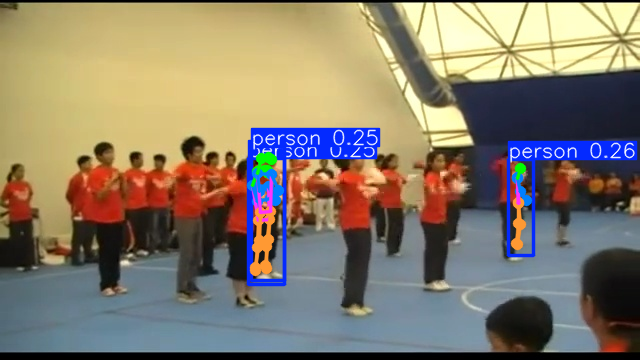

In [26]:
# Visualize the result and get the resized image

pil_image = Image.open(frame_file.get_path())

if not frame_annotations[0][2].is_detected:
    im_rgb = pil_image
else: 
    # Convert RGB to BGR
    rgb_array = np.asarray(pil_image)
    
    if rgb_array.ndim == 3 and rgb_array.shape[2] == 3:
        bgr_array = rgb_array[:, :, ::-1]
    else:
        # If the image is not RGB (e.g., grayscale or RGBA), return as is
        bgr_array = rgb_array
    
    r = ur.engine.results.Results(
        bgr_array,
        path=frame_file.get_path(),
        names={0: 'person'},
        boxes=boxes.data,
        keypoints=keypoints.data,
    )


visualize_ultralytics_results(r, scale=1)

## Visualize frames for a list of `video_id` 

Let's adapt this algorithm to visualize pose detections for list of `video_id` 

In [27]:
from src.ultralitics_utils import fetch_frame_ids, process_frame2results

In [28]:
def plot_results(dc, video_ids, conf=0.5, top_k=10,  cols=4, figsize=(15, 3)):
    """Plot the detection results for all videos in a subplot grid."""
    
    # Calculate total frames to plot and rows needed
    total_frames = top_k * len(video_ids)
    rows = total_frames // cols + (total_frames % cols > 0)
    
    # Create a figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], rows * figsize[1]))
    axes = axes.flatten()  # Flatten axes for easy iteration

    idx = 0  # Track subplot index
    for vid in video_ids:

        # Select Detections with confidence >= "conf" and show top_k only
        dc_pose = (
            dc
            .filter(C("frame.video_id") == vid)
            .filter(C("pose.confidence") >= conf)
            .order_by("frame.frame_id", descending=False)
            .limit(top_k)   
            .save()  # Need to apply this filter
        )

        # Extract frame IDs selected in "dc_pose"
        frame_ids = fetch_frame_ids(dc_pose)

        # Show all Detections for each selected frames
        for fid in frame_ids:
            
            if idx >= axes.size:
                print(f"Reached subplot limit. Skipping further frames for video {vid}.")
                break

            # Fetch frame annotations and frame image file
            frame_annotations = list(dc_pose.filter(C("frame.frame_id") == fid).collect("file", "frame", "pose"))
            img_file = frame_annotations[0][0]
            pose_detections = [annotation[2] for annotation in frame_annotations]
        
            # Convert Detections into Ultralitics' Results object and get annotated image
            r = process_frame2results(img_file, pose_detections)
            im_rgb = visualize_ultralytics_results(r, scale=1)

            # Plot image in the corresponding subplot
            ax = axes[idx]
            ax.imshow(im_rgb)
            ax.axis('off')  # Hide axes
            ax.set_title(f"{'/'.join(frame_file.get_path().split('/')[-2:])}")

            idx += 1  # Move to the next subplot

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


Saving: 10 rows [00:00, 3679.21 rows/s]
Saving: 10 rows [00:00, 3815.43 rows/s]
Saving: 10 rows [00:00, 3953.91 rows/s]


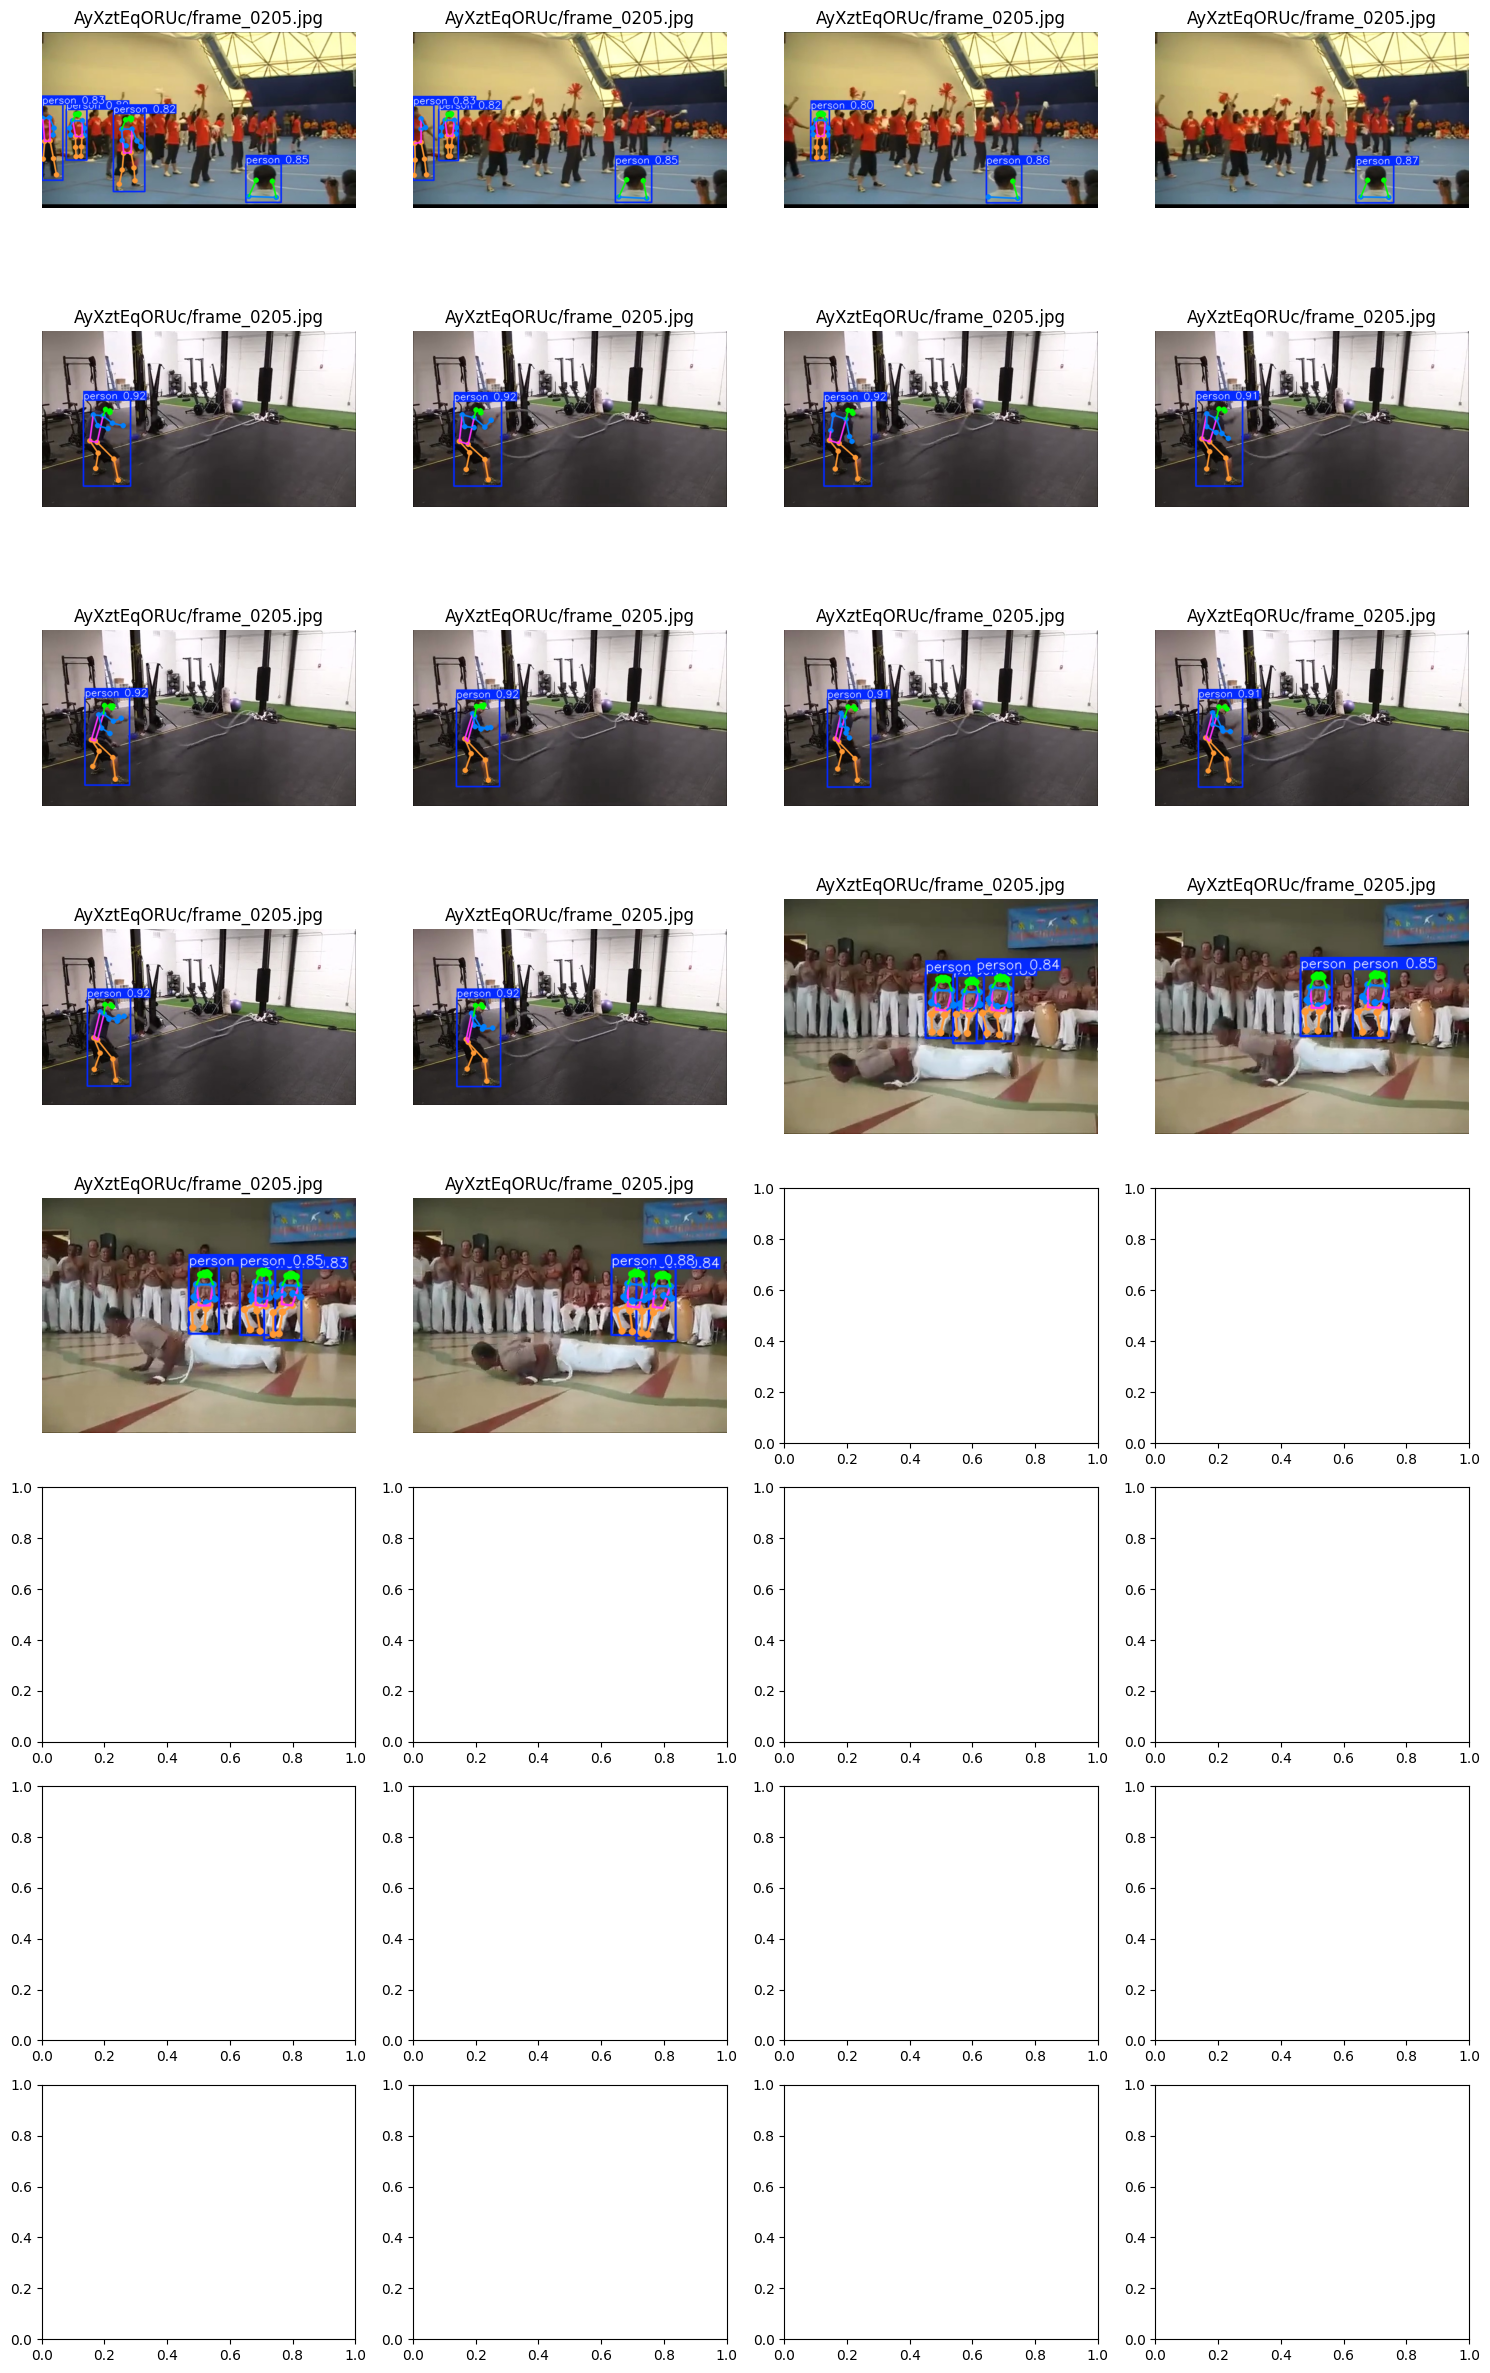

In [29]:
# Example usage
dc_pose = DataChain.from_dataset('k700-top-frames-pose')

video_ids = ['AyXztEqORUc', 'BBB1iQAihGY', 'hhjIaWoVHVM']
plot_results(dc_pose, video_ids, top_k=10,  conf=0.8, cols=4, figsize=(15, 3))

# 🎉 Summary 

👏 **Congratulations on completing this tutorial!** 

We are happy to hear about your insights and use case. Please, don't hesitate to share your thoughts and feature requests! 

How to update this into your project? 
1. Design DataModel classes for metadata and annotations
2. Create DataChains for media files and annotations (from cloud buckets, folders, json, csv, etc.)
3. Merge media and annotation DataChains for easy processing and filtering
4. Add utils and visualizations for DataChains.

🤝 **Get Involved**

We'd love to have you join our growing community of DataChain users and contributors! Here's how you can get involved:

- ⭐ Give us a star on [GitHub](https://github.com/iterative/datachain) to show your support
- 🌐 Visit the [datachain.ai website](https://datachain.ai/) to learn more about our products and services
- 📞 Contact us to discuss on scaling 🚀 DataChain for your project!
- 🙌 Follow us on [LinkedIn](https://www.linkedin.com/company/dvc-ai/) and [Twitter](https://x.com/DVCorg) for the latest updates and insights

Thanks for choosing DataChain, and happy coding! 😄